# Document Processing Pipeline

**12-Step CamScanner-style Document Processing**

This notebook demonstrates our complete document processing pipeline, broken down into 12 detailed steps.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure display
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Paths
TEST_DIR = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
if 'test_outputs' not in TEST_DIR:
    TEST_DIR = os.path.join(TEST_DIR, 'test_outputs') if os.path.exists(os.path.join(TEST_DIR, 'test_outputs')) else TEST_DIR

print(f"Working directory: {TEST_DIR}")

Working directory: c:\Users\chama\OneDrive\Desktop\printchakra\backend\test\test_outputs


## Processing Functions

Core functions for document processing pipeline

In [2]:
def order_points(pts):
    """Order points: top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def four_point_transform(image, pts):
    """Apply perspective transform"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))


def find_document(image):
    """Detect document boundaries"""
    scale = 0.25
    small = cv2.resize(image, (0, 0), fx=scale, fy=scale)
    gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    for low, high in [(30, 100), (50, 150), (75, 200)]:
        edges = cv2.Canny(blurred, low, high)
        edges = cv2.dilate(edges, np.ones((2, 2)), iterations=2)
        contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        
        for c in contours:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                area = cv2.contourArea(approx)
                if area > small.shape[0] * small.shape[1] * 0.1:
                    return (approx.reshape(4, 2) / scale).astype(np.float32)
    return None


print("✓ Processing functions loaded")

✓ Processing functions loaded


## Step 1: Load Original Image

Load the raw image from camera/scanner input.

✓ Loaded image: 3472x4624 pixels


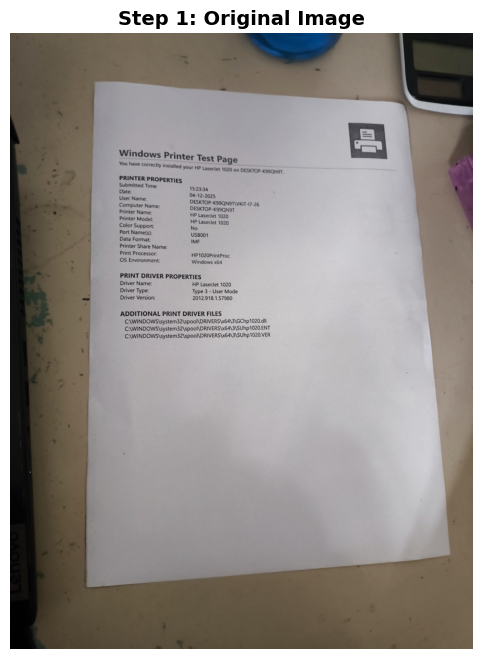

In [3]:
# Step 1: Load original image
image_path = os.path.join(TEST_DIR, 'original.jpg')
if not os.path.exists(image_path):
    # Try parent directory
    image_path = os.path.join(os.path.dirname(TEST_DIR), 'original.jpg')

original = cv2.imread(image_path)
if original is None:
    print(f"Error: Could not load image from {image_path}")
else:
    print(f"✓ Loaded image: {original.shape[1]}x{original.shape[0]} pixels")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Step 1: Original Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

## Step 2: Downscale for Detection

Downscale the image for faster edge detection processing.

✓ Downscaled to: 868x1156 pixels (scale=0.25)


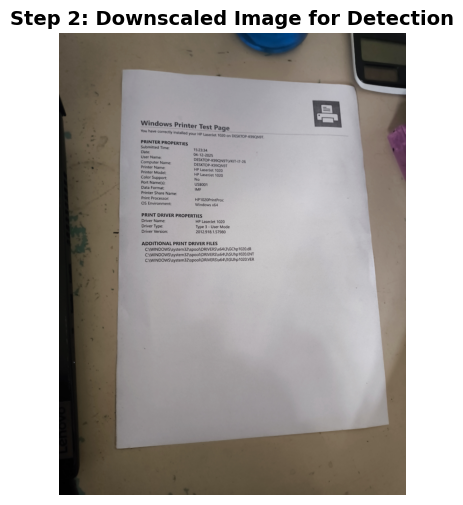

In [4]:
# Step 2: Downscale for detection
scale = 0.25
small = cv2.resize(original, (0, 0), fx=scale, fy=scale)
print(f"✓ Downscaled to: {small.shape[1]}x{small.shape[0]} pixels (scale={scale})")

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
plt.title('Step 2: Downscaled Image for Detection', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 3: Convert to Grayscale (Detection)

Convert the downscaled image to grayscale for edge detection.

✓ Converted to grayscale


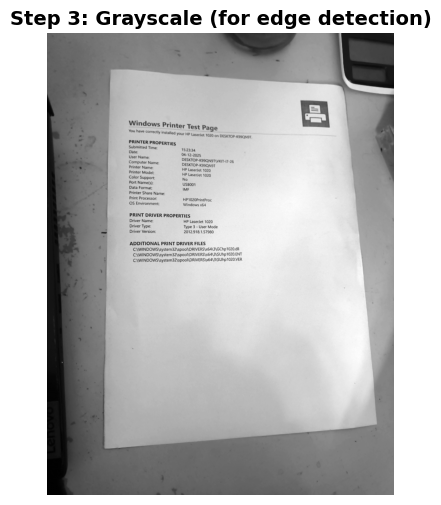

In [5]:
# Step 3: Convert to grayscale for detection
gray_small = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
print(f"✓ Converted to grayscale")

plt.figure(figsize=(8, 6))
plt.imshow(gray_small, cmap='gray')
plt.title('Step 3: Grayscale (for edge detection)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 4: Gaussian Blur

Apply Gaussian blur to reduce noise before edge detection.

✓ Applied Gaussian blur (5x5)


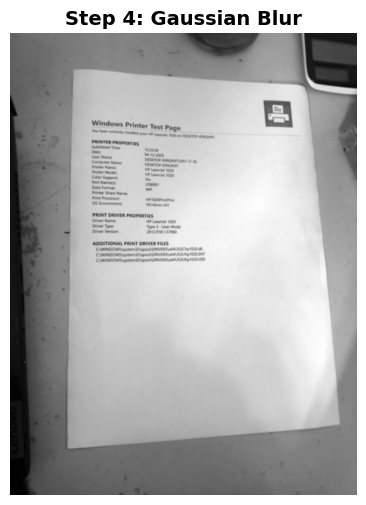

In [6]:
# Step 4: Gaussian blur
blurred = cv2.GaussianBlur(gray_small, (5, 5), 0)
print(f"✓ Applied Gaussian blur (5x5)")

plt.figure(figsize=(8, 6))
plt.imshow(blurred, cmap='gray')
plt.title('Step 4: Gaussian Blur', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 5: Canny Edge Detection

Apply Canny edge detection to find document boundaries.

✓ Canny edge detection applied (50, 150)


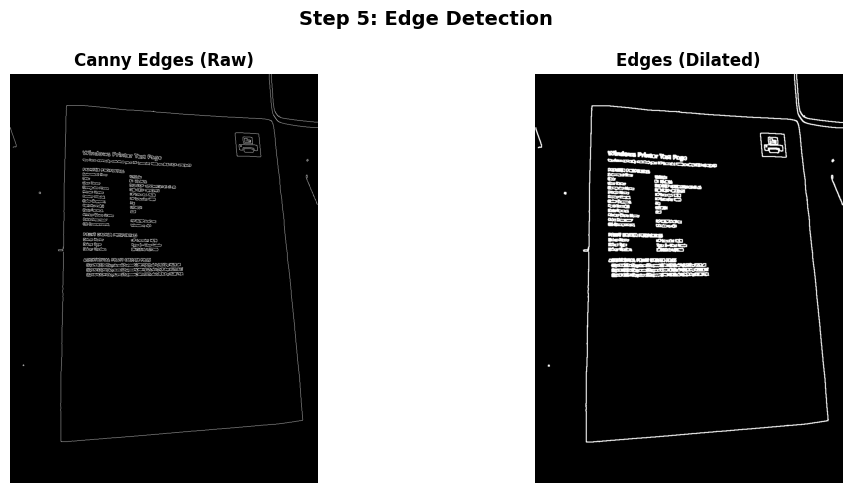

In [7]:
# Step 5: Canny edge detection
edges = cv2.Canny(blurred, 50, 150)
edges_dilated = cv2.dilate(edges, np.ones((2, 2)), iterations=2)
print(f"✓ Canny edge detection applied (50, 150)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Canny Edges (Raw)', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(edges_dilated, cmap='gray')
axes[1].set_title('Edges (Dilated)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.suptitle('Step 5: Edge Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Find Document Contour

Find the largest quadrilateral contour representing the document.

✓ Document detected with 4 corners


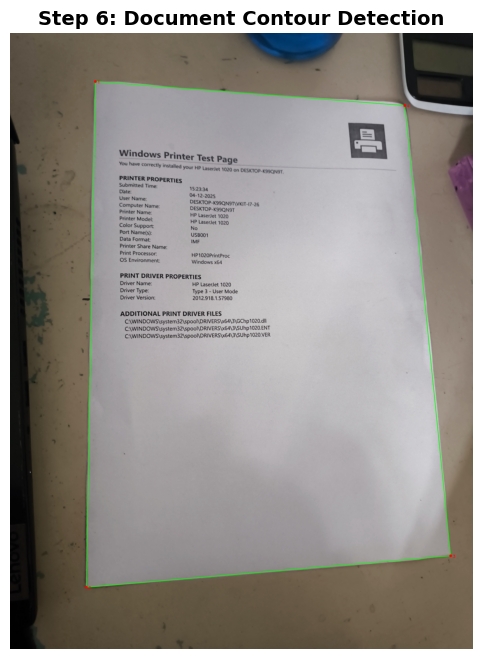

In [8]:
# Step 6: Find document contour
pts = find_document(original)

vis = original.copy()
if pts is not None:
    pts_int = pts.astype(int)
    cv2.polylines(vis, [pts_int], True, (0, 255, 0), 3)
    for i, pt in enumerate(pts_int):
        cv2.circle(vis, tuple(pt), 10, (0, 0, 255), -1)
        cv2.putText(vis, str(i+1), tuple(pt + 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    print(f"✓ Document detected with 4 corners")
else:
    print("! No document detected")

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Step 6: Document Contour Detection', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 7: Perspective Transform (Crop)

Apply perspective transformation to get a bird's-eye view of the document.

✓ Perspective corrected: 2742x3796 pixels


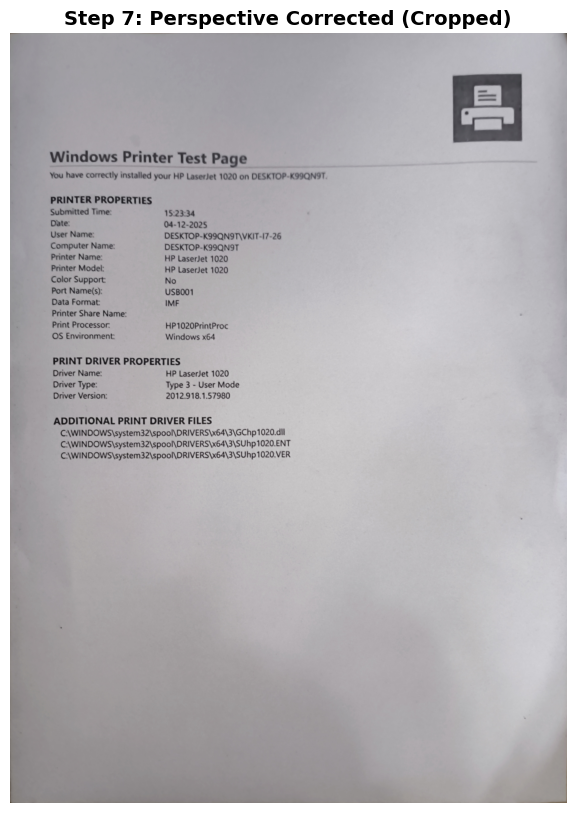

In [9]:
# Step 7: Perspective transform
if pts is not None:
    warped = four_point_transform(original, pts)
    print(f"✓ Perspective corrected: {warped.shape[1]}x{warped.shape[0]} pixels")
else:
    warped = original
    print("! Using original image (no document detected)")

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Step 7: Perspective Corrected (Cropped)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 8: Convert to Grayscale (Processing)

Convert the cropped document to grayscale for enhancement.

✓ Converted to grayscale: 2742x3796


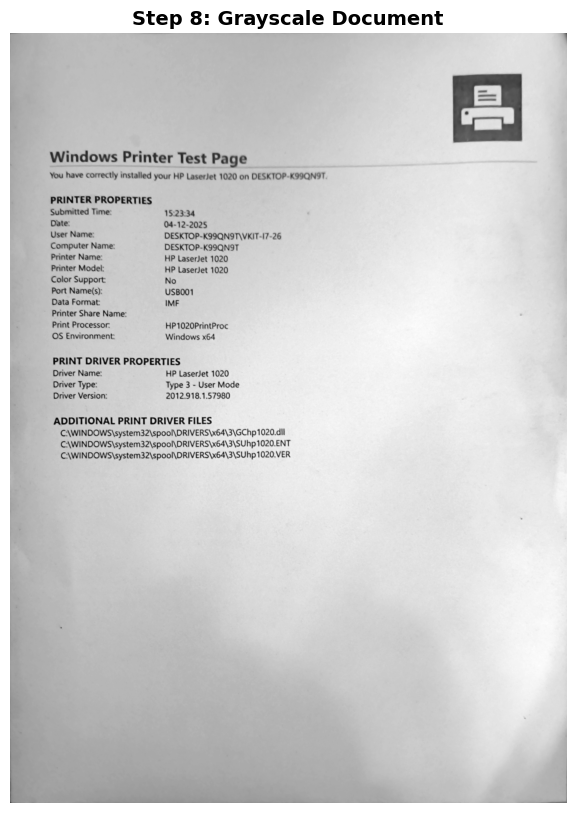

In [10]:
# Step 8: Convert to grayscale
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
print(f"✓ Converted to grayscale: {gray.shape[1]}x{gray.shape[0]}")

plt.figure(figsize=(8, 10))
plt.imshow(gray, cmap='gray')
plt.title('Step 8: Grayscale Document', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 9: Downscale for Background Estimation

Downscale for faster morphological operations.

✓ Background processing scale: 0.21
  Downscaled to: 577x800


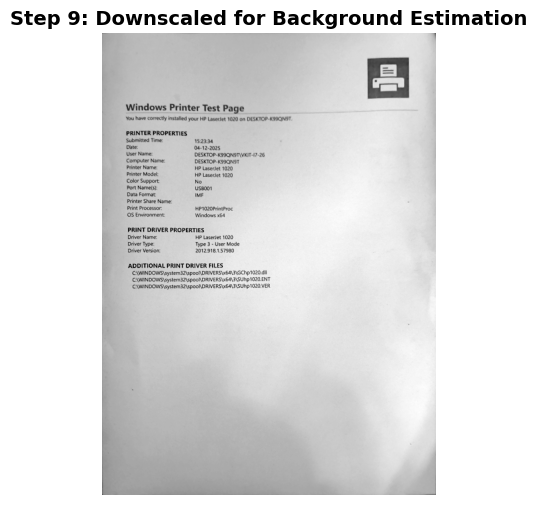

In [11]:
# Step 9: Downscale for background estimation
h, w = gray.shape
max_dim = 800
bg_scale = min(max_dim / max(h, w), 1.0)

if bg_scale < 1.0:
    small_gray = cv2.resize(gray, (int(w * bg_scale), int(h * bg_scale)))
else:
    small_gray = gray

print(f"✓ Background processing scale: {bg_scale:.2f}")
print(f"  Downscaled to: {small_gray.shape[1]}x{small_gray.shape[0]}")

plt.figure(figsize=(8, 6))
plt.imshow(small_gray, cmap='gray')
plt.title('Step 9: Downscaled for Background Estimation', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 10: Morphological Background Estimation

Use morphological closing to estimate the background illumination.

✓ Background estimated with kernel size: 101x101


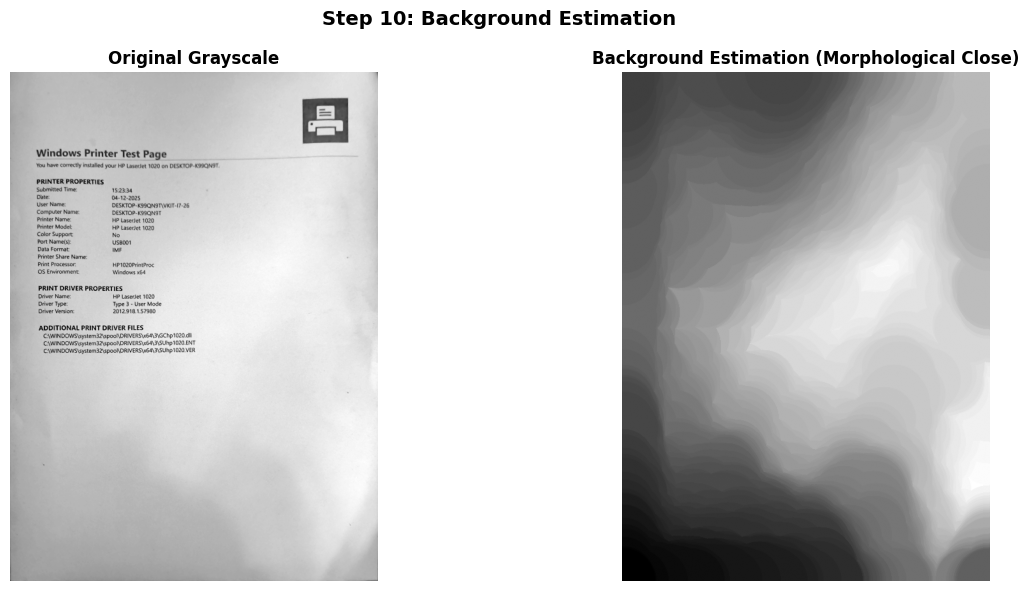

In [12]:
# Step 10: Morphological background estimation
sh, sw = small_gray.shape
k = max(sh, sw) // 8
k = k if k % 2 == 1 else k + 1
k = max(31, min(k, 127))

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
bg_raw = cv2.morphologyEx(small_gray, cv2.MORPH_CLOSE, kernel)

print(f"✓ Background estimated with kernel size: {k}x{k}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(small_gray, cmap='gray')
axes[0].set_title('Original Grayscale', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(bg_raw, cmap='gray')
axes[1].set_title('Background Estimation (Morphological Close)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.suptitle('Step 10: Background Estimation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 11: Smooth and Upscale Background

Smooth the background and upscale back to original resolution.

✓ Background smoothed and upscaled to: 2742x3796


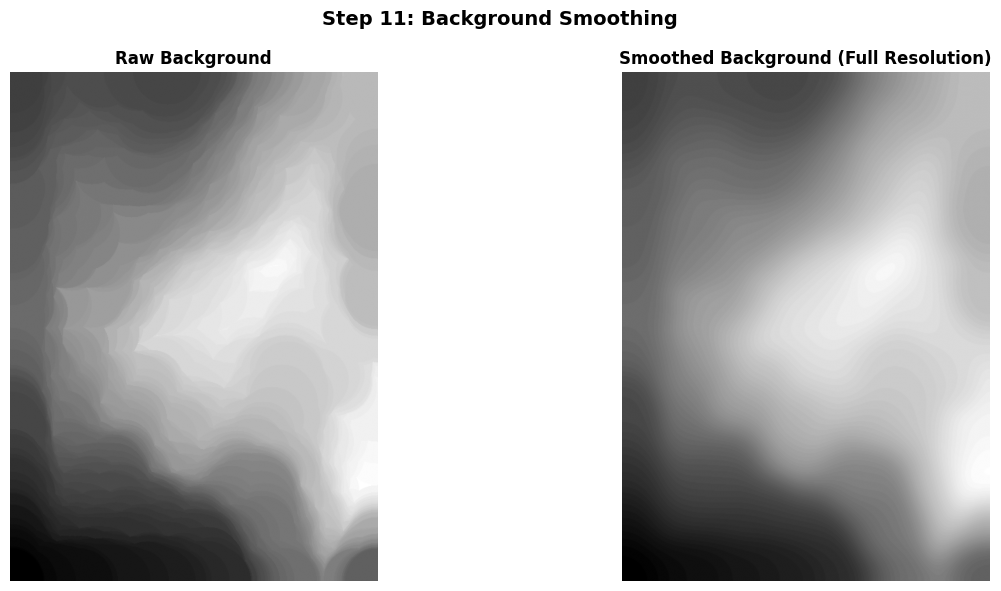

In [13]:
# Step 11: Smooth and upscale background
bg_smoothed = cv2.GaussianBlur(bg_raw, (k, k), 0)

if bg_scale < 1.0:
    bg = cv2.resize(bg_smoothed, (w, h), interpolation=cv2.INTER_LINEAR)
    bg = cv2.GaussianBlur(bg, (31, 31), 0)
else:
    bg = bg_smoothed

print(f"✓ Background smoothed and upscaled to: {bg.shape[1]}x{bg.shape[0]}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(bg_raw, cmap='gray')
axes[0].set_title('Raw Background', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(bg, cmap='gray')
axes[1].set_title('Smoothed Background (Full Resolution)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.suptitle('Step 11: Background Smoothing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 12: Shadow Removal (Final Output)

Normalize illumination by dividing by background to remove shadows.

**Formula:** `result = (pixel / background) × 255`

✓ Shadow removal complete
  Formula: result = (pixel / background) × 255


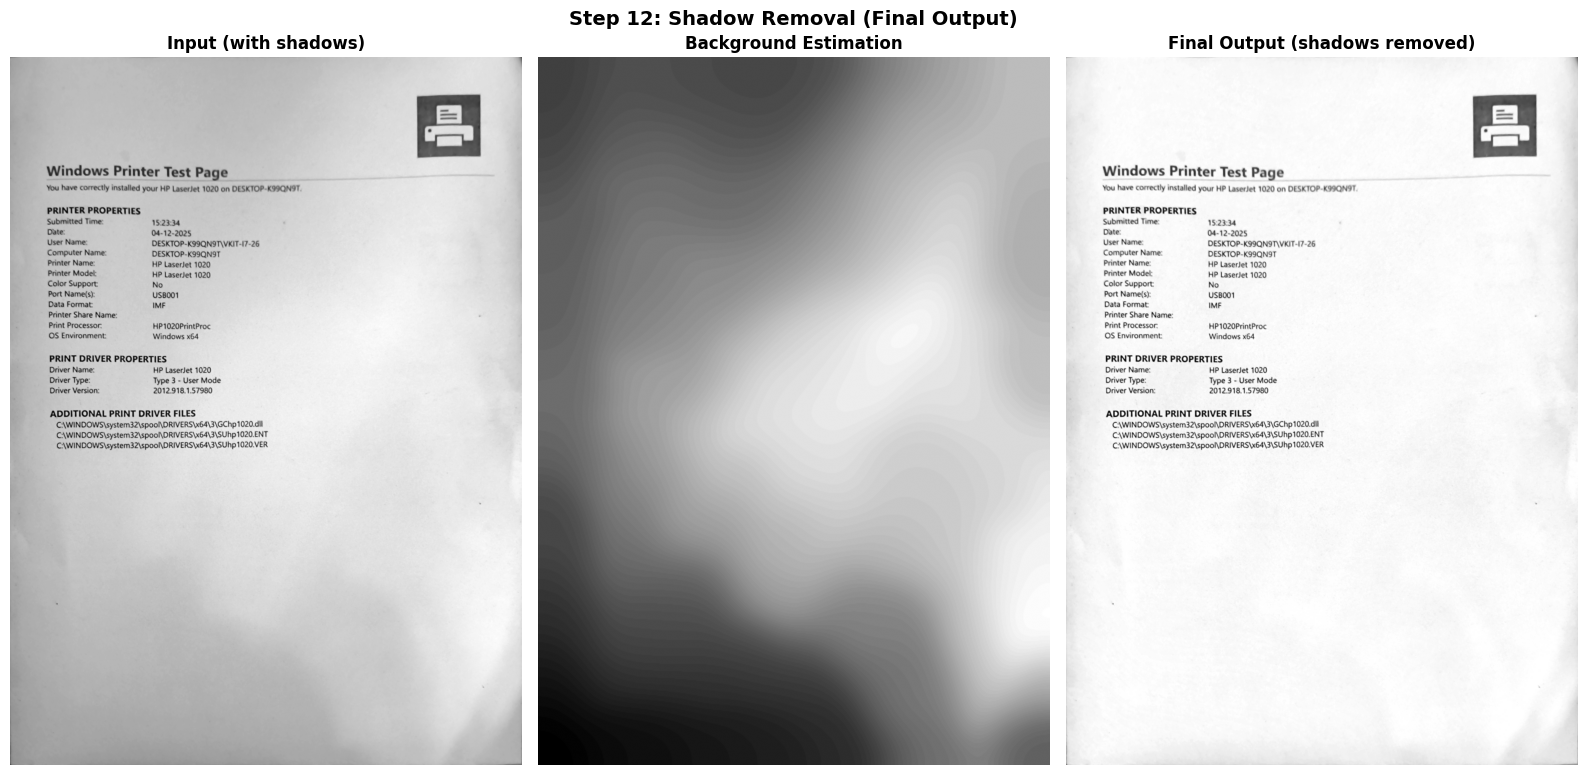

In [14]:
# Step 12: Shadow removal (illumination normalization)
result = np.zeros_like(gray, dtype=np.float32)
mask = bg > 10
result[mask] = (gray[mask].astype(np.float32) / bg[mask].astype(np.float32)) * 255
result = np.clip(result, 0, 255).astype(np.uint8)

print(f"✓ Shadow removal complete")
print(f"  Formula: result = (pixel / background) × 255")

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Input (with shadows)', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(bg, cmap='gray')
axes[1].set_title('Background Estimation', fontsize=12, fontweight='bold')
axes[1].axis('off')
axes[2].imshow(result, cmap='gray')
axes[2].set_title('Final Output (shadows removed)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.suptitle('Step 12: Shadow Removal (Final Output)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Pipeline Summary

Complete overview of all 12 processing steps.

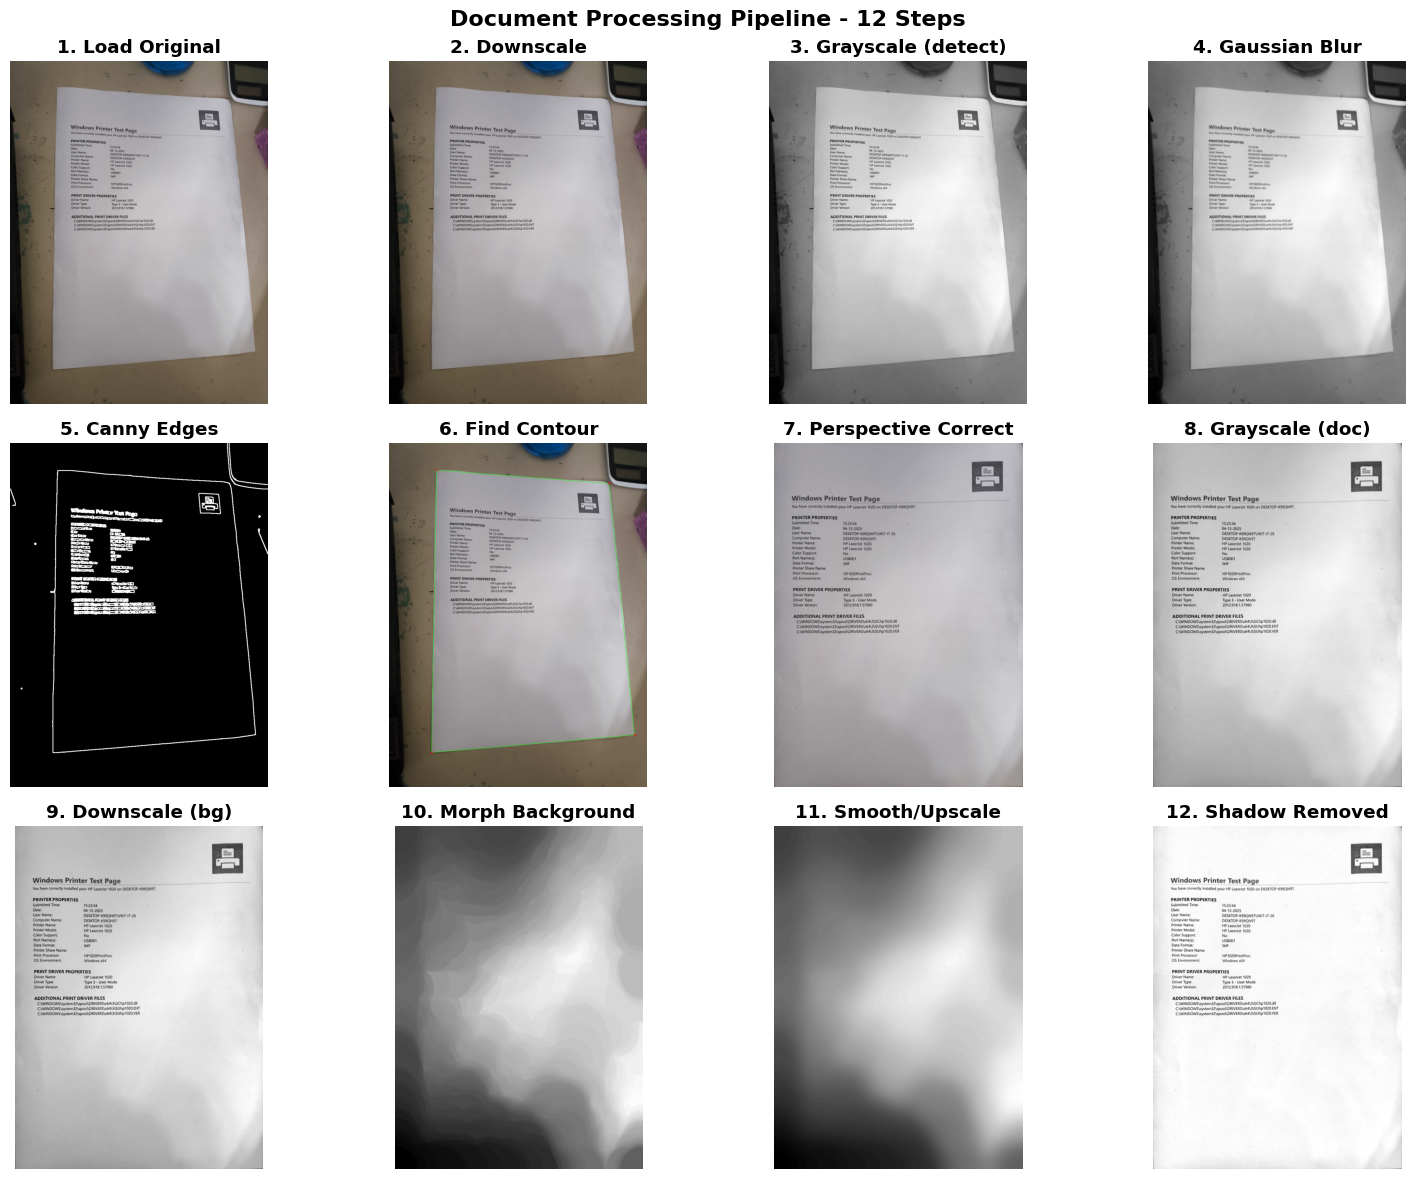


PIPELINE SUMMARY - 12 STEPS

| Step | Stage                      | Description                    |
|------|----------------------------|--------------------------------|
| 1    | Load Original              | Load raw image from input      |
| 2    | Downscale (Detection)      | Reduce size for faster edges   |
| 3    | Grayscale (Detection)      | Convert to grayscale           |
| 4    | Gaussian Blur              | Reduce noise for edge detect   |
| 5    | Canny Edge Detection       | Find edges in image            |
| 6    | Find Document Contour      | Locate 4-corner document       |
| 7    | Perspective Transform      | Correct skew, crop document    |
| 8    | Grayscale (Processing)     | Convert cropped doc to gray    |
| 9    | Downscale (Background)     | Reduce for morphology ops      |
| 10   | Morphological Background   | Estimate background lighting   |
| 11   | Smooth/Upscale Background  | Smooth and restore resolution  |
| 12   | Shadow Removal (Output)    | Normalize

In [15]:
# Pipeline summary visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Row 1: Steps 1-4
axes[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Load Original', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('2. Downscale', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(gray_small, cmap='gray')
axes[0, 2].set_title('3. Grayscale (detect)', fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(blurred, cmap='gray')
axes[0, 3].set_title('4. Gaussian Blur', fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Steps 5-8
axes[1, 0].imshow(edges_dilated, cmap='gray')
axes[1, 0].set_title('5. Canny Edges', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('6. Find Contour', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('7. Perspective Correct', fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(gray, cmap='gray')
axes[1, 3].set_title('8. Grayscale (doc)', fontweight='bold')
axes[1, 3].axis('off')

# Row 3: Steps 9-12
axes[2, 0].imshow(small_gray, cmap='gray')
axes[2, 0].set_title('9. Downscale (bg)', fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(bg_raw, cmap='gray')
axes[2, 1].set_title('10. Morph Background', fontweight='bold')
axes[2, 1].axis('off')

axes[2, 2].imshow(bg, cmap='gray')
axes[2, 2].set_title('11. Smooth/Upscale', fontweight='bold')
axes[2, 2].axis('off')

axes[2, 3].imshow(result, cmap='gray')
axes[2, 3].set_title('12. Shadow Removed', fontweight='bold')
axes[2, 3].axis('off')

plt.suptitle('Document Processing Pipeline - 12 Steps', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PIPELINE SUMMARY - 12 STEPS")
print("="*70)
print("""
| Step | Stage                      | Description                    |
|------|----------------------------|--------------------------------|
| 1    | Load Original              | Load raw image from input      |
| 2    | Downscale (Detection)      | Reduce size for faster edges   |
| 3    | Grayscale (Detection)      | Convert to grayscale           |
| 4    | Gaussian Blur              | Reduce noise for edge detect   |
| 5    | Canny Edge Detection       | Find edges in image            |
| 6    | Find Document Contour      | Locate 4-corner document       |
| 7    | Perspective Transform      | Correct skew, crop document    |
| 8    | Grayscale (Processing)     | Convert cropped doc to gray    |
| 9    | Downscale (Background)     | Reduce for morphology ops      |
| 10   | Morphological Background   | Estimate background lighting   |
| 11   | Smooth/Upscale Background  | Smooth and restore resolution  |
| 12   | Shadow Removal (Output)    | Normalize illumination         |
""")